# Simulating neural computation with Brian 2
## Preliminary remarks: the jupyter notebook
The [jupyter notebook](http://jupyter.readthedocs.io/) is a tool to mix text, code, and results/figures generated by the code in a single document that can be shared and remains editable.

We here use it with Python, but support for other programming languages exists.

Code written in a cell will be executed when you press `Ctrl+Enter` or `Shift+Enter` (this will also jump to the next code cell, or open a new code cell if none exists):

In [1]:
3 + 4 -3

4

In [2]:
6 * 4

24

In [3]:
x = 7

Note that cells can be executed in arbitrary order, which can potentially get confusing. E.g. changing the value of `x` above after executing the cell below will make the two cells inconsistent. You can determine the order of evaluations by looking at the number in square brackets in front of each cell. However, this is not foolprof, e.g. if you change the content of a cell without re-executing it, the number does not change. To make sure that a document does not have any such oddities in it, you can run it from scratch by chosing `Kernel --> Restart & Run All` in the menu.

In [4]:
x + 4

11

Text can be formatted using the light-way formatting language [markdown](https://daringfireball.net/projects/markdown/syntax). You can have for example text in *italics* or **bold**. It also allows you to write mathematical expressions using LaTeX syntax: $\sqrt 2$ (double click a formatted cell to see its "source code")

## Using Brian – Neuron models
Let's import "everything" from the Brian 2 package.

This also provides access to the scientific computing package [numpy](http://www.numpy.org/) (imported as `np`), and to the package `pyplot` from the plotting library [matplotlib](http://matplotlib.org) (imported as `plt`).

In [5]:
from brian2 import *

We also switch off Brian's "code generation" mechanism, which improves the performance for complex models by generating/compiling/executing C++ code "behind the scenes". For the simple models that we are covering in this tutorial, this is not necessary – it even slows down things due to the need for compilation.

In [6]:
prefs.codegen.target = 'numpy'

We also ask the notebook to include plots directly in the notebook (instead of showing them in a separate window). Note that lines starting with `%` are specific commands for the jupyter notebook, they won't work in a Python script, for example. (We use this specific command here because the matplotlib version installed on the machines in the computer room is quite old. In general, a better choice is `%matplotlib notebook` which enables plots that are zoomable, etc.)

In [7]:
%matplotlib inline

Let's start using Brian! Brian provides a system for physical units:

In [8]:
Rm = 1*Mohm
I = 50*nA

In [9]:
Rm

1. * Mohm

Operations with physical quantities lead to new quantities with potentially different units:

In [10]:
I*10000

0.5 * mamp

In [11]:
Rm * I

50. * mvolt

Brian will complain if operations do not make sense:

In [12]:
Rm + I

DimensionMismatchError: Cannot calculate 1. Mohm + 50. nA, units do not match (units are ohm and amp).

(Python error messages are very verbose: have a look at the *end* of the error message first!)

Let's define a simplified integrate-and-fire model (note that during most of the course, we used the model with a `-` missing, i.e. with a leak current driving the membrane potential *away* from the leak current instead towards it..., this has been fixed in this notebook): 

In [13]:
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
I_e = 1*nA
eqs = 'dVm/dt = (-G_leak*(Vm - E_leak) + I_e)/Cm : volt'
neurons = NeuronGroup(1, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak')
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.20s). [brian2.stateupdaters.base.method_choice]


We can now look a the membrane potential after the 100ms:

In [14]:
neurons.Vm

<neurongroup.Vm: array([-65.59974818]) * mvolt>

If we want to look at the development of the membrane potential over time, we'll have to tell Brian to record the values of `V` during the simulation. From now on, we'll also add call to `start_scope()` at the beginning of each new model. `start_scope` is a Brian function that is only needed when executing many models in a jupyter notebook. It tells Brian to forget about all previous simulations. This is not necessary all the time, e.g. in the following code blocks we will overwrite the neurons variable, therefore there is no ambiguity as to which model should be simulated. As soon as models get more complex and have multiple components, it can become messy otherwise.

Let's also get rid of the information about the integration algorithm: Brian emits this message because we did not explicitly say how the equations should be integrated. In this case, Brian decides which integration algorithm to use and tells us about its choice. In our case, the equations are simple enough to be solved analytically, we therefore chose the method 'exact' (other options would be for example 'euler' to integrate with the --fast but not accurate-- forward Euler, or 'rk4' to integrate with a fourth-order Runge-Kutta method):

In [15]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
I_e = 1*nA
eqs = 'dVm/dt = (-G_leak*(Vm - E_leak) + I_e)/Cm : volt'
neurons = NeuronGroup(1, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
monitor = StateMonitor(neurons, 'Vm', record=True)
run(100*ms)

Now we can plot the values using Python's plotting library. Note that we divide the physical quantitities by the scale we are interested in to get values "in ms" or "in mV":

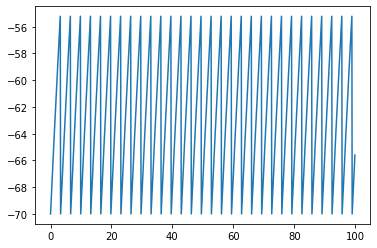

In [16]:
plt.plot(monitor.t/ms, monitor.Vm[0]/mV)

As expected, the neuron fires regularly in response to the constant current injection.
(Note that for a visualization in a paper, you'd probably add a vertical line for each spike to make the membrane potential look "more realistic")

To get rid of the distracting "Out" line, we can add a semicolon at the end of the line (something that is only relevant to the last line of a code cell when running things in an interactive environment like the jupyter notebook -- you *don't* have to add a semicolon to every line!).

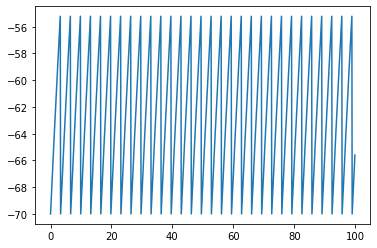

In [17]:
plt.plot(monitor.t/ms, monitor.Vm[0]/mV);

Constants defined outside of the equations (e.g. $\tau_m$ in our case) are the same for all neurons in a group. If we want to have neuron-specific values, we'll have to include them in the equations. We do this for a constant current input $I_{ext}$ that can have differing strengths for each neuron. We can set this value in the same way that we set the initial value of the membrane potential; by declaring $I_{ext}$ in the model equations it becomes accessible as an attribute of `neurons`:

In [18]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_ext)/Cm : volt
         I_ext : amp'''
neurons = NeuronGroup(3, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons.I_ext = [0.1, 0.5, 1.0]*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
run(100*ms)

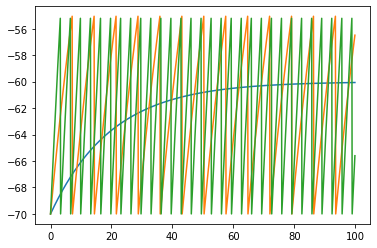

In [19]:
plt.plot(monitor.t/ms, monitor.Vm[0]/mV)
plt.plot(monitor.t/ms, monitor.Vm[1]/mV)
plt.plot(monitor.t/ms, monitor.Vm[2]/mV);

To plot the voltages of all neurons at once, we can plot `monitor.Vm` (instead of `monitor.Vm[0]` etc.). However, matplotlib wants the first dimension (i.e., the number of rows) of `monitor.Vm` to be the same as the dimension of `monitor.t`, but the first dimension of `monitor.Vm` is the neuron index in Brian. We therefore have to transpose the matrix, i.e. use `monitor.Vm.T`:

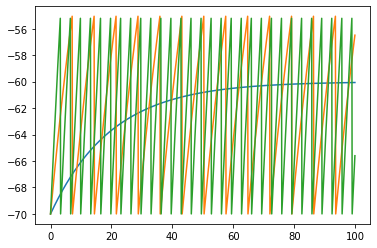

In [20]:
plt.plot(monitor.t/ms, monitor.Vm.T/mV);

Let usintroduce a new monitor, a `pikeMonitor` that only records the spiking activity the cells, i.e. the time of spikes and the index of the neuron that emitted it.

In [21]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_ext)/Cm : volt
         I_ext : amp'''
neurons = NeuronGroup(3, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons.I_ext = [0.25, 0.5, 1.0]*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
spike_monitor = SpikeMonitor(neurons)
run(100*ms)

If we plot the indices of the neurons that spiked against the time of the spike, we get a classical "raster plot":

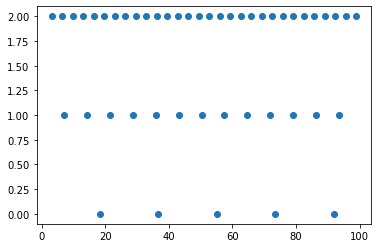

In [22]:
plt.plot(spike_monitor.t/ms, spike_monitor.i, 'o');

The neuron with the weakest input (on the bottom) emits fewer spikes than the neurons with stronger inputs. To quantitfy this more systematically, let's use 100 neurons and vary the input current between 0nA and 0.5nA in 100 steps (using numpy's [`linspace` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)):

In [23]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_ext)/Cm : volt
         I_ext : amp'''
neurons = NeuronGroup(100, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons.I_ext = np.linspace(0, 0.5, 100)*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
spike_monitor = SpikeMonitor(neurons)
run(100*ms)

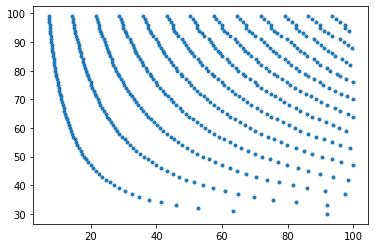

In [24]:
plt.plot(spike_monitor.t/ms, spike_monitor.i, '.');

The raster plot shows some interesting patterns, but to more clearly see the relationship between the firing rate $f$ and the input current $I$, we'll plot a so-called "f/I curve", i.e. the firing rate over the input current. For this, we can use the total spike count that is stored for every neuron in the variable `count` of the `SpikeMonitor`:

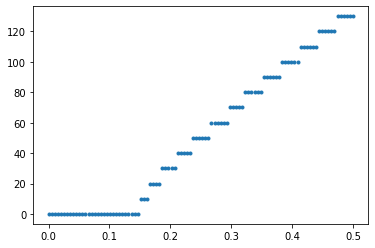

In [25]:
plt.plot(neurons.I_ext/nA, spike_monitor.count/(100*ms) ,'.');

This shows that a current of around 0.15nA is needed to elicit spikes, and stronger currents elicit more spikes in an approximately proportional fashion. Note that there are a weird steps in the plot -- this is simply because of our short simulation time: we cannot have "half a spike", so e.g. a current that is stronger than a current that elicits 9 spikes during our 100ms simulation, can only either also elicit 9 spikes (no change in the plot) or 10 spikes (jump by 10 Hz). There are various ways to make this estimation better (e.g. run multiple simulations with the same current but use different initial values for the membrane potential), but the easiest is to simply run a longer simulation:

In [26]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_ext)/Cm : volt
         I_ext : amp'''
neurons = NeuronGroup(100, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons.I_ext = np.linspace(0, 0.5, 100)*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
spike_monitor = SpikeMonitor(neurons)
run(1000*ms)

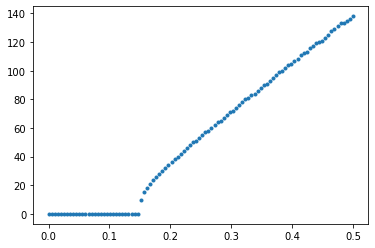

In [27]:
plt.plot(neurons.I_ext/nA, spike_monitor.count/(1000*ms) ,'.');

How does this curve change with changes in the capacitance ($Cm$) and the leak conductance ($G_\text{leak}$) of the cell? We simply tried this out during the course, but a slightly more systematic evaluation could look like this:

In [28]:
start_scope()
G_leak = 10*nS
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_ext)/Cm_variable : volt
         I_ext : amp
         Cm_variable : farad'''
neurons = NeuronGroup(3*100, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
# We use three different values for Cm (called Cm_variable here), and
# use the full range of current values for each
neurons.Vm = E_leak
# We can refer to a subset of the neuron's with Python's "slicing notation"
neurons[0:100].Cm_variable = 100*pF  # first 100 neurons
neurons[0:100].I_ext = np.linspace(0, 0.5, 100)*nA
neurons[100:200].Cm_variable = 200*pF  # next 100 neurons
neurons[100:200].I_ext = np.linspace(0, 0.5, 100)*nA
neurons[200:300].Cm_variable = 400*pF  # last 100 neurons
neurons[200:300].I_ext = np.linspace(0, 0.5, 100)*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
spike_monitor = SpikeMonitor(neurons)
run(1000*ms)

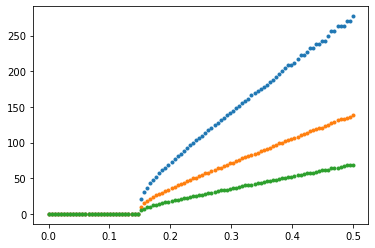

In [29]:
plt.plot(neurons.I_ext[0:100]/nA, spike_monitor.count[0:100]/(1000*ms) ,'.')
plt.plot(neurons.I_ext[100:200]/nA, spike_monitor.count[100:200]/(1000*ms) ,'.')
plt.plot(neurons.I_ext[200:300]/nA, spike_monitor.count[200:300]/(1000*ms) ,'.');

A change in capacitance changes the slope of the f/I curve, while the minimal current to elicit a spike is unchanged.

We do the same analysis for the leak conductance:

In [30]:
start_scope()
Cm = 200*pF
E_leak = -70*mV
eqs = '''dVm/dt = (-G_leak_variable*(Vm - E_leak) + I_ext)/Cm : volt
         I_ext : amp
         G_leak_variable : siemens'''
neurons = NeuronGroup(3*100, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons[0:100].G_leak_variable = 5*nS  # first 100 neurons
neurons[0:100].I_ext = np.linspace(0, 0.5, 100)*nA
neurons[100:200].G_leak_variable = 10*nS  # next 100 neurons
neurons[100:200].I_ext = np.linspace(0, 0.5, 100)*nA
neurons[200:300].G_leak_variable = 20*nS  # last 100 neurons
neurons[200:300].I_ext = np.linspace(0, 0.5, 100)*nA
monitor = StateMonitor(neurons, 'Vm', record=True)
spike_monitor = SpikeMonitor(neurons)
run(1000*ms)

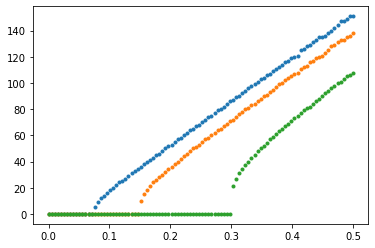

In [31]:
plt.plot(neurons.I_ext[0:100]/nA, spike_monitor.count[0:100]/(1000*ms) ,'.')
plt.plot(neurons.I_ext[100:200]/nA, spike_monitor.count[100:200]/(1000*ms) ,'.')
plt.plot(neurons.I_ext[200:300]/nA, spike_monitor.count[200:300]/(1000*ms) ,'.');

A change in the leak conductance has a very different effect, it leaves the slope of the curve unaffected, but shifts the curve along the x axis: with a stronger leak conductance, a stronger current is needed to elicit a spike.

## Using Brian – Synapse models

The "input" our cell received in the previous model was a constant current input. While we can inject constant currents into neurons during an experiment, the membrane potential of neurons under normal conditions is mostly affect by the temporary currents arising from the impact of chemical synapses. As a first step towards modeling such synapses, we make our current temporary (decaying explonentionally to zero). We'll also record the evolution of this current over time by including it in our `StateMonitor`:

In [32]:
start_scope()
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
tau_syn = 5*ms
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_syn)/Cm : volt
         dI_syn/dt = -I_syn/tau_syn : amp'''
neurons = NeuronGroup(1, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak
neurons.I_syn = 0.5*nA
monitor = StateMonitor(neurons, ['Vm', 'I_syn'], record=True)
spike_monitor = SpikeMonitor(neurons)
run(100*ms)

We'll use the `subplots` function to create two rows (and one colum) of plots, the ax variable is now a list of two axes that we can index with `[..]` (remember that indices in Python start at 0):

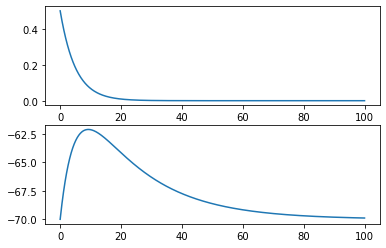

In [33]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(monitor.t/ms, monitor.I_syn[0]/nA)
ax[1].plot(monitor.t/ms, monitor.Vm[0]/mV);

Let's leave aside our neural model for a moment and look at other ways to generate spikes, useful to serve as input to a network of neurons. One useful way of generating inputs is the `PoissonGroup`, which generates spikes generated by a Poisson process. You can provide individual firing rates for each neuron, or a single firing rate for all neurons:

In [34]:
start_scope()
input_spikes = PoissonGroup(10, rates=100*Hz)
input_monitor = SpikeMonitor(input_spikes)
run(100*ms)

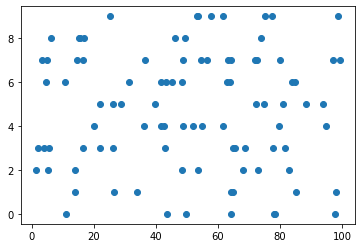

In [35]:
plt.plot(input_monitor.t/ms, input_monitor.i, 'o');

All neurons fire with the same rate (the total number of spikes recorded over a long time will be the same), but each firing pattern is stochastic and independent of the other neurons. We are now going to connect this source of spikes to our neuron model defined previously. We do this using the `Synapses` class which in addition to the source and target groups, requires us to specify the action that the arrival of a presynaptic spike (hence: `on_pre`) causes. Creating such a `Synapses` object will not yet create synapses (there are many ways in which you could connect two groups), we will have to call the `connect` function to do this. Calling `connect()` without any arguments means: "connect everything in the source group to everything in the target group" (i.e., "all-to-all"):

In [36]:
start_scope()
input_spikes = PoissonGroup(10, rates=100*Hz)
input_monitor = SpikeMonitor(input_spikes)
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
tau_syn = 5*ms
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_syn)/Cm : volt
         dI_syn/dt = -I_syn/tau_syn : amp'''
neurons = NeuronGroup(1, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak

synapses = Synapses(input_spikes, neurons, '',
                    on_pre='I_syn += 0.05*nA')
synapses.connect()

monitor = StateMonitor(neurons, ['Vm', 'I_syn'], record=True)
spike_monitor = SpikeMonitor(neurons)
run(100*ms)

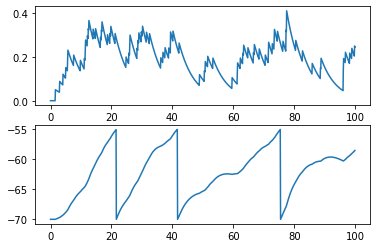

In [37]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(monitor.t/ms, monitor.I_syn[0]/nA)
ax[1].plot(monitor.t/ms, monitor.Vm[0]/mV);

The current plotted in the top row jumps up by a small amount each time a spike from one of the 10 Poisson neurons arrives. The effect of these spikes is the same (a jump of 0.05nA), regardless of which Poisson neuron emitted the spike. This is not the most interesting situation – in fact, 10 Poisson neurons spiking at 100Hz are mathematically identical to a single Poisson neuron spiking at 1000Hz. Synapses in the brain can greatly vary in efficacy, and the pattern of synaptic connections and strengths is what is widely believed to be the major way that the brain stores memories. We are far from addressing questions like this here, but as a tiny first step, let us make the synaptic strength part of the synaptic model (which was previously empty, i.e. the empty string `''`) and set it to values between 0 and 0.1nA:

In [38]:
start_scope()
input_spikes = PoissonGroup(10, rates=100*Hz)
input_monitor = SpikeMonitor(input_spikes)
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
tau_syn = 5*ms
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_syn)/Cm : volt
         dI_syn/dt = -I_syn/tau_syn : amp'''
neurons = NeuronGroup(1, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak

synapses = Synapses(input_spikes, neurons, 'w : amp',
                    on_pre='I_syn += w')
synapses.connect()
synapses.w = np.linspace(0, 0.1, 10)*nA

monitor = StateMonitor(neurons, ['Vm', 'I_syn'], record=True)
spike_monitor = SpikeMonitor(neurons)
run(100*ms)

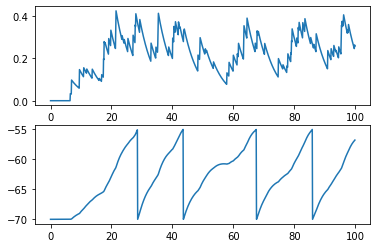

In [39]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(monitor.t/ms, monitor.I_syn[0]/nA)
ax[1].plot(monitor.t/ms, monitor.Vm[0]/mV);

If you look closely at the synaptic current in the top row, you'll now notice that some synaptic events are very small, while others are relatively big.

Now that we have a somewhat "realistic" input (random spike events instead of a constant current injection), we can do a similar analysis to the f/I curve earlier. We change our model to have 100 Poisson neurons and 100 integrate-and-fire neurons, connected in a one-to-one pattern. We then vary the firing rate of the Poisson neurons systematically, so that we can see how the "output" firing rate of a neuron depends on its "input" firing rate (but note that the synaptic strength of course matters as well).

In [40]:
start_scope()
input_spikes = PoissonGroup(100, rates=np.linspace(0, 100, 100)*Hz)
input_monitor = SpikeMonitor(input_spikes)
Cm = 200*pF
G_leak = 10*nS
E_leak = -70*mV
tau_syn = 5*ms
eqs = '''dVm/dt = (-G_leak*(Vm - E_leak) + I_syn)/Cm : volt
         dI_syn/dt = -I_syn/tau_syn : amp'''
neurons = NeuronGroup(100, eqs, threshold='Vm>-55*mV',
                      reset='Vm = E_leak', method='exact')
neurons.Vm = E_leak

synapses = Synapses(input_spikes, neurons, 'w : amp',
                    on_pre='I_syn += w')
synapses.connect(j='i')  # one-to-one connection pattern
synapses.w = 0.5*nA

monitor = StateMonitor(neurons, ['Vm', 'I_syn'], record=True)
spike_monitor = SpikeMonitor(neurons)
run(1000*ms)

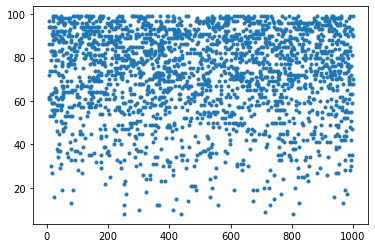

In [41]:
plt.plot(spike_monitor.t/ms, spike_monitor.i, '.');

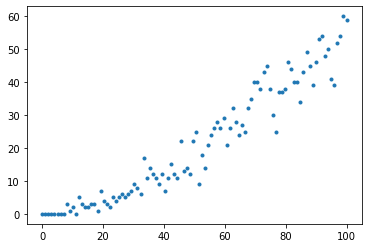

In [42]:
plt.plot(input_spikes.rates, spike_monitor.count, '.');

This looks similar to the f/I curve we created earlier (there's a minimal value needed to elicit spikes, output firing rate grows approximately proportionally with input firing rate), but also important differences. Note that the curve looks much noiser than the previous curve, this is mostly because we are using the "theoretical" firing rate on the x axis: a Poisson neuron with a requested firing rate of 50Hz might well elicit only 48 spikes during our simulation, while a Poisson neuron with a requested firing rate of 49Hz might elicit 51 spikes. Running the simulation for longer, averaging over multiple runs, or simply using the actual number of elicited spikes on the x axis would all make the curve smoother.